# Generate a frequency distribution

I would really like to see a frequency distribution, because this would help me think about whether the patterns we see here are roughly neutral or not

In [1]:
import imp
import importlib, json
import glob
import re,copy,json
import requests
import pandas as pd 
import numpy as np
    
import rpy2
%load_ext rpy2.ipython

In [2]:
# define colors

# powerful women palette
s_color = "#ADC1CB"
ns_color = "#5D7481"
intergenic_region_color = "#ECC58C"
fs_color = "#95727F"
fs_stop_color = "#551E32"

#purple: 5248AA
#blue: 7C9BAC
#yellow: ECC58C
#red: 551E32
#green:434A42

# old blue/green palette
# s_color = "#A5CDA2"
# ns_color = "#0E7908"
# stop_color = "#073C04"
# fs_color = "#00357D"
# fs_stop_color = "#00142F"

In [3]:
# define which column we want to use to look at variants. Use 'nuc_muts' to characterize variants relative to the 
# Wuhan 1 reference, or 'minor_nuc_muts' to do a consensus-agnostic comparison
variant_column = 'minor_nuc_muts'
frequency_column = 'minor_frequency'

## Read in vcfs and convert to dataframe

In [4]:
"""to load in an ipython notebook as a module, just run the following. You will now have access to all of the 
functions written in that jupyter notebook"""

%run vcf-module.ipynb

In [5]:
# read in the current date 
from datetime import date
today = date.today()
current_date = str(today.strftime("%Y-%m-%d"))

In [6]:
"""now, input the strain names file/metadata file, the directory containing the vcfs, and return the dataframess"""

strain_names_file = "/Users/lmoncla/src/ncov-WI-within-host/data/sample-metadata.tsv"
fasta_file = "../data/consensus-sequences-2021-01-25.fasta"
clades_file = "../data/clades-file-2020-08-28.txt"
vcf_directory = "../data/vcfs-all/"

# N transcript was a control; sample/tube 6, UW-30, has an snv at basically every single site after a certain 
# point in the genome. it has 418 SNVs!!! I'm excluding it; finally, I am going to exclude tube 127, USA/WI-UW-118/2020
# which has >50 indels and >50 SNVs. It has a pretty high Ct as well, so I think these are probably errors as it is 
# a very clear outlier
# remove 302, 303, 304, 302, 735, and 736 because these are time-series! 
samples_to_ignore = ["N_transcript","127","302","303","304","735","736"]

# set the length of homopolymers that you want to use
homopolymer_length = 3

# set the variant percent that you want to use 
variant_percent = "0.03"

snvs_only, all_intersection_variants,metadata_dict, strain_names_dict = return_dataframes(strain_names_file, clades_file,vcf_directory,samples_to_ignore,fasta_file, homopolymer_length)

In [7]:
"""gather twist sites"""
twist_sites = snvs_only[snvs_only['sampleid'] == "twist_rna"]['POS_x'].tolist()

"""remove all rows containing variants at twist sites"""
snvs_only = snvs_only[~snvs_only['POS_x'].isin(twist_sites)]

In [10]:
"""subset data to include only SNVs and indels >3% frequency"""
snvs_only = snvs_only[snvs_only[frequency_column] >= float(variant_percent)]

"""subset data to include only SNVs and indels <50% frequency"""
snvs_only = snvs_only[snvs_only[frequency_column] <= float(0.5)]


In [11]:
set(snvs_only['annotation'].tolist())

{'intergenic-region', 'intergenic_region', 'missense', 'stop', 'synonymous'}

## Functions for converting dataframes into frequency spectra

In [12]:
def transform_percent(value: float):    
    if value <= 0.1:
        return('3-10%')
    elif value > 0.1 and value <=0.2: 
        return('10-20%')
    elif value > 0.2 and value <=0.3: 
        return('20-30%')
    elif value > 0.3 and value <=0.4: 
        return('30-40%')
    elif value > 0.4 and value <=0.5: 
        return('40-50%')
    elif value > 0.5 and value <=0.6: 
        return('50-60%')
    elif value > 0.6 and value <=0.7: 
        return('60-70%')
    elif value > 0.7 and value <=0.8: 
        return('70-80%')
    elif value > 0.8 and value <=0.9: 
        return('80-90%')
    elif value > 0.9 and value <=1.0: 
        return('90-100%')

In [13]:
def generate_frequency_bins(df):
    # assign bins to each SNP frequency value
    temp_df = pd.DataFrame(df)
    bin_series = df['minor_frequency'].apply(transform_percent)
    temp_df["bin"] = bin_series
    return(df)

In [14]:
def generate_counts_df(df):
    
    df_to_return = pd.DataFrame()
    
    # combine the in-frame deletions into a single category
    df['annotation'] = df['annotation'].replace("conservative-inframe-deletion","inframe_deletion")
    df['annotation'] = df['annotation'].replace("disruptive-inframe-deletion","inframe_deletion")
    df['annotation'] = df['annotation'].replace("intergenic-region","intergenic_region")
    
    for strain in set(df['strain_name'].tolist()):
        for mut_type in set(df['annotation'].tolist()):
            d = df[(df['strain_name'] == strain) & (df['annotation'] == mut_type)]
            d = d[['bin']]
            d = pd.DataFrame(d.groupby(['bin']).size())
            d.reset_index(inplace=True)
            d.columns = ['bin','count']
            total_snvs = d['count'].sum()
            d['proportion'] = d['count']/total_snvs
            d['strain_name'] = strain
            d['type'] = mut_type

            df_to_return = df_to_return.append(d)
    

    return(df_to_return)

In [15]:
def count_total_number_variants_per_type(df):
    
    print("total number of each type of variant in dataset: ")
    types = list(set(df['type'].tolist()))
    for t in types:
        d = df[df['type']== t]
        print(t, len(d))

In [16]:
# add in frequency bins and generate a counts dataframe
snvs_freq1 = generate_frequency_bins(snvs_only)
snvs_freq = generate_counts_df(snvs_freq1)
print(set(snvs_freq['type'].tolist()))
count_total_number_variants_per_type(snvs_freq)
snvs_freq.head()

{'missense', 'intergenic_region', 'synonymous', 'stop'}
total number of each type of variant in dataset: 
missense 100
intergenic_region 23
synonymous 116
stop 1


,bin,count,proportion,strain_name,type
0,3-10%,1,1.0,USA/WI-UW-188/2020,synonymous
0,10-20%,1,1.0,USA/WI-UW-598/2020,missense
0,3-10%,1,1.0,USA/WI-UW-598/2020,intergenic_region
0,3-10%,4,1.0,USA/WI-UW-598/2020,synonymous
0,3-10%,4,1.0,USA/WI-UW-897/2020,missense


In [17]:
# repeat for indels
# indels_freq1 = generate_frequency_bins(indels_only)
# indels_freq = generate_counts_df(indels_freq1)
# indels_freq['type'] = indels_freq['type'].str.replace("intergenic_region","intergenic_region_deletion")
# print(set(indels_freq['type'].tolist()))
# count_total_number_variants_per_type(indels_freq)
# indels_freq.head()

## First, make a plot of the total number of different types of variants found across the dataset 

In the frequency spectrum I'm making below, I am currently plotting the proportion of each type of variant that is found across frequency bins. I am doing this by taking for each sample and mutation type, what proportion of variants are found across different bins. So for example, for sample A, synonymous variants, what fraction are found between 1-10%? 10-20%?, etc... The problem with this is that for variant types that are rare (like stop variants), it doesn't really show adequately that there are very few detected overall in the dataset, and that most samples don't have any of those types of variants. So I'm going to add a new type of plot here where I just plot the total number of variants across frequency bins for each type. This will show overall counts instead of proportions. 

In [18]:
# we will now make a dataframe that contains for each bin and type, the total number of variants in the dataset
counts_freq_spec = pd.DataFrame(snvs_freq.groupby(['bin','type']).size())
counts_freq_spec.reset_index(inplace=True)
counts_freq_spec.columns = ["bin","type","total"]
counts_freq_spec.head()

,bin,type,total
0,10-20%,intergenic_region,2
1,10-20%,missense,10
2,10-20%,synonymous,18
3,20-30%,intergenic_region,3
4,20-30%,missense,7


In [19]:
counts_freq_spec

,bin,type,total
0,10-20%,intergenic_region,2
1,10-20%,missense,10
2,10-20%,synonymous,18
3,20-30%,intergenic_region,3
4,20-30%,missense,7
5,20-30%,synonymous,3
6,3-10%,intergenic_region,18
7,3-10%,missense,70
8,3-10%,stop,1
9,3-10%,synonymous,88


In [20]:
s_color = "#ADC1CB"
ns_color = "#551E32"
intergenic_region_color = "#ECC58C"
fs_color = "#95727F"
fs_stop_color = "#551E32"


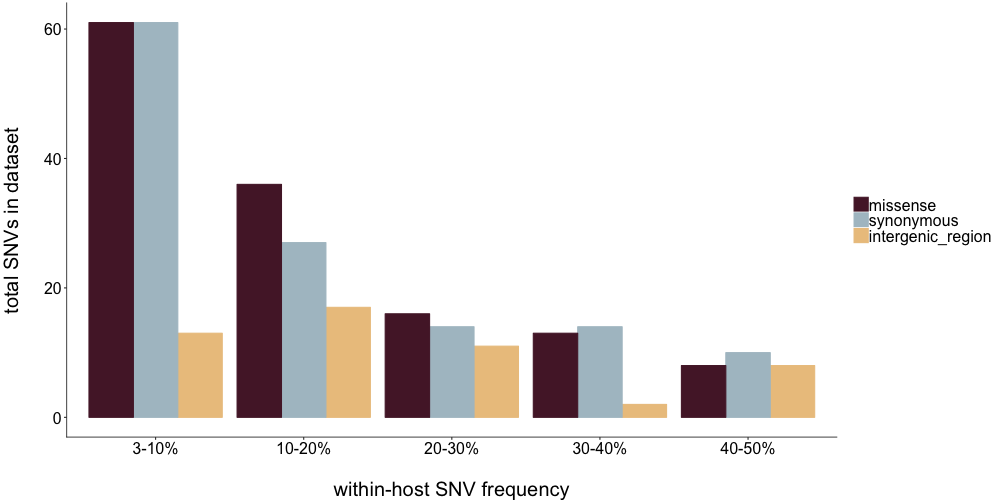

In [70]:
%%R -w 1000 -h 500 -u px -i current_date,variant_percent,counts_freq_spec,s_color,ns_color,fs_color,fs_stop_color,intergenic_region_color # this sets the size of the plot...otherwise, it will go off the page\n",
require(ggplot2)
library(ggplot2)

output_filename = paste("frequency-spectrum-counts-",variant_percent,"percent-",current_date,".pdf", sep="")

counts_freq_spec$type <- gsub('&', '_', counts_freq_spec$type)
counts_freq_spec$type <- gsub('-', '_', counts_freq_spec$type)
counts_freq_spec$typef = factor(counts_freq_spec$type, levels=c("stop","missense","synonymous","intergenic_region","frameshift","frameshift_stop","inframe_deletion","intergenic_region_deletion"))
counts_freq_spec$binf = factor(counts_freq_spec$bin, levels=c("3-10%","10-20%","20-30%","30-40%","40-50%"))


p4 <- ggplot(counts_freq_spec, aes(x=binf, y=total, color=typef, fill=typef, group=typef))+
    geom_col(position = position_dodge(preserve = "single") )+
    scale_color_manual(values=c(missense=ns_color, synonymous=s_color,frameshift=fs_color,intergenic_region=intergenic_region_color))+
    scale_fill_manual(values=c(missense=ns_color, synonymous=s_color,frameshift=fs_color,intergenic_region=intergenic_region_color))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+
    theme(plot.title=element_text(size=13))+
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(plot.margin=unit(c(0.1,0.1,0.1,0.1),"cm"))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=20, hjust=0.5, vjust=0.5))+
    theme(axis.title.x=element_text(size=20, vjust=0.5))+
    theme(axis.text.y=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(hjust=0.5, size=16, colour="black"))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_blank())+
    #theme(legend.position = c(0.9, 0.6))+ # (0,0) is bottom left, (1,1) is top right
    theme(panel.margin=unit(1, "lines"))+
    theme(legend.key.size=unit(0.55, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    labs(x="\nwithin-host SNV frequency",y="total SNVs in dataset\n")
#       scale_y_continuous(limits=c(-0.1,1.2), breaks=seq(0,1.2,0.2))+


ggsave(output_filename, p4, width = 12, height = 5, path="../figures/individual-pdfs/")
p4

### Calculate mean and standard errors

We really should have error bars on these plots

In [21]:
def fill_in_missing_values(values,sampling_value):
    missing_values = sampling_value - len(values)
    
    for i in range(missing_values):
        values.append(0.0)
    return(values)

In [22]:
def bootrap_values(values, iterations, sampling_value):
    bootstrapped_means = []
    
    for i in range(iterations):
        sample = np.random.choice(values, sampling_value, replace=True)
        mean = np.asarray(sample).mean()
        bootstrapped_means.append(mean)
    
    bootstrapped_means_array = np.array(bootstrapped_means)
    a = np.quantile(bootstrapped_means_array, 0.975)
    b = np.quantile(bootstrapped_means_array, 0.025)
    c = np.std(bootstrapped_means_array)
    
    return(a,b,c)

In [23]:
def run_bootstrap_iterations(df, iterations):
    
    freq_spec = pd.DataFrame()

    for p in set(df['type'].tolist()):
                    
        # I am setting sampling value down here because we only want to fill in missing bins for the type
        x = df[df['type'] == p]
        sampling_value = len(set(x['strain_name'].tolist())) # setting this so that we fill in missing values for all strains

        for freq_bin in set(df['bin'].tolist()):

            d = df[(df['bin'] == freq_bin) & (df['type'] == p)]
            values = d['proportion'].tolist()

            values = fill_in_missing_values(values,sampling_value)
            mean = np.asarray(values).mean()
            a,b,c = bootrap_values(values, iterations, sampling_value)

            # generate dataframe 
            x = pd.DataFrame({"bin":[freq_bin],"type":[p],"mean":[mean],
                                "bootstrap_lower":[b],"bootstrap_upper":[a],"se_mean":[c]})
            freq_spec = freq_spec.append(x)
            
    return(freq_spec)

In [46]:
snvs_freq.head()

,bin,count,proportion,strain_name,type
0,3-10%,1,1.0,USA/WI-UW-188/2020,synonymous
0,10-20%,1,1.0,USA/WI-UW-598/2020,missense
0,3-10%,1,1.0,USA/WI-UW-598/2020,intergenic_region
0,3-10%,4,1.0,USA/WI-UW-598/2020,synonymous
0,3-10%,4,1.0,USA/WI-UW-897/2020,missense


In [47]:
snvs_freq[snvs_freq['type']=="stop"]

,bin,count,proportion,strain_name,type
0,3-10%,1,1.0,USA/WI-UW-784/2020,stop


In [25]:
freq_spec = run_bootstrap_iterations(snvs_freq,1000)
freq_spec.head()

,bin,type,mean,bootstrap_lower,bootstrap_upper,se_mean
0,10-20%,missense,0.066458,0.026625,0.113130,0.023586
0,30-40%,missense,0.049375,0.011875,0.096875,0.022291
0,20-30%,missense,0.061250,0.017500,0.117500,0.025578
0,40-50%,missense,0.032083,0.010417,0.057500,0.012153
0,3-10%,missense,0.790833,0.712911,0.860635,0.039078


### Add in neutral expectation as a dashed line

The expectation for the proportion of variants in each frequency bin is given by a 1/x distribution. I will integrate the area under the curve for a 1/x distribution between each interval and plot this expected value. 

In [26]:
from scipy.integrate import quad

def integrate_over_bins(lower_bound,upper_bound):
    # generate lambda function for 1/x
    f= lambda x:(1/x)

    # integrate between bins 
    integral = quad(f, lower_bound, upper_bound)[0]
    return(integral)

In [27]:
def return_area_under_curve(bins):

    total_area_under_curve = 0
    integrals = []
    
    for i in range(len(bins)-1):
        lower_bound = bins[i]
        upper_bound = bins[i+1]
        integral = integrate_over_bins(lower_bound,upper_bound)
        integrals.append(integral)
        
    total_area_under_curve = np.asarray(integrals).sum()
    return(total_area_under_curve, integrals)

In [28]:
def return_neutral_expectation(total_area_under_curve, integrals):
    proportions = []
    for i in integrals: 
        proportion = i/total_area_under_curve
        proportions.append(proportion)
        
    return(proportions)

In [29]:
bins = [0.01,0.1,0.2,0.3,0.4,0.5]
#bins = [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
total_area_under_curve, integrals = return_area_under_curve(bins)
proportions = return_neutral_expectation(total_area_under_curve, integrals)
neutral_df = pd.DataFrame({"bin":["3-10%","10-20%","20-30%","30-40%","40-50%"],"expected":proportions})
#neutral_df = pd.DataFrame({"bin":["3-10%","10-20%","20-30%","30-40%","40-50%","50-60%","60-70%","70-80%","80-90%","90-100%"],"expected":proportions})

mutation_types = list(set(freq_spec['type'].tolist()))
types = []
for m in mutation_types:
    for i in range(len(neutral_df)):
        types.append(m)

        
target_length = len(types)
current_length = len(neutral_df)
number_append = target_length/current_length
neutral_df = pd.concat([neutral_df]*int(number_append))
neutral_df['type'] = types
neutral_df.head()

,bin,expected,type
0,3-10%,0.588592,missense
1,10-20%,0.177184,missense
2,20-30%,0.103646,missense
3,30-40%,0.073538,missense
4,40-50%,0.057040,missense


In [44]:
freq_spec_neutral = freq_spec.merge(neutral_df, on=["bin","type"], how="outer")
freq_spec_neutral = freq_spec_neutral.fillna(0)
freq_spec_neutral.head()

,bin,type,mean,bootstrap_lower,bootstrap_upper,se_mean,expected
0,10-20%,missense,0.066458,0.026625,0.113130,0.023586,0.177184
1,30-40%,missense,0.049375,0.011875,0.096875,0.022291,0.073538
2,20-30%,missense,0.061250,0.017500,0.117500,0.025578,0.103646
3,40-50%,missense,0.032083,0.010417,0.057500,0.012153,0.057040
4,3-10%,missense,0.790833,0.712911,0.860635,0.039078,0.588592


In [31]:
print(mutation_types)

['missense', 'stop', 'intergenic_region', 'synonymous']


In [40]:
s_color = "#ADC1CB"
ns_color = "#5D7481"
intergenic_region_color = "#95727F"##"#ECC58C"#"#551E32"#
stop_color = "#551E32"

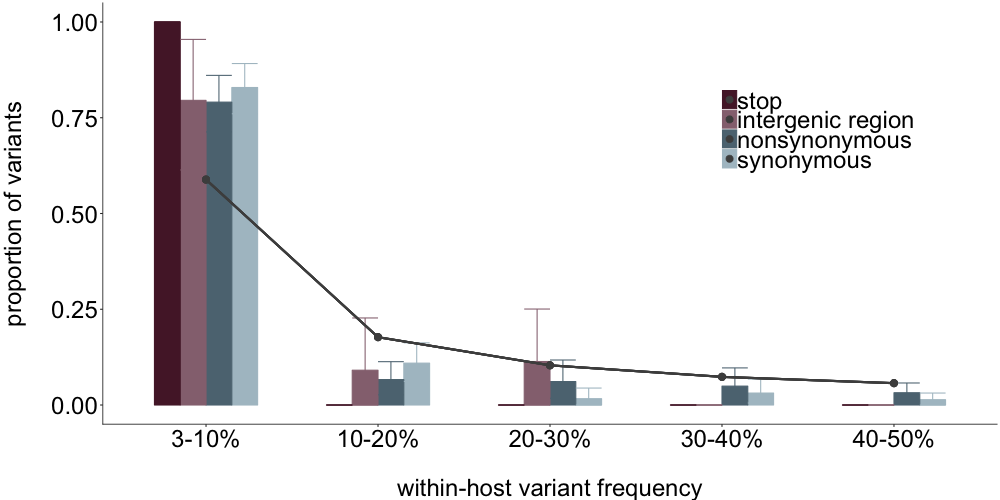

In [50]:
%%R -w 1000 -h 500 -u px -i variant_percent,current_date,freq_spec_neutral,s_color,ns_color,intergenic_region_color # this sets the size of the plot...otherwise, it will go off the page\n",
require(ggplot2)
library(ggplot2)

output_filename = paste("frequency-spectrum-proportions2-",variant_percent,"percent-",current_date,".pdf", sep="")

# # get rid of the types of variants for which we have very few
# freq_spec_neutral <- freq_spec_neutral[(freq_spec_neutral$type != "stop"),]
# freq_spec_neutral <- freq_spec_neutral[(freq_spec_neutral$type != "inframe_deletion"),]
# freq_spec_neutral <- freq_spec_neutral[(freq_spec_neutral$type != "intergenic_region_deletion"),]

# set bins and types as factors
freq_spec_neutral$type <- gsub('&', '_', freq_spec_neutral$type)
freq_spec_neutral$type <- gsub('-', '_', freq_spec_neutral$type)
freq_spec_neutral$typef = factor(freq_spec_neutral$type, levels=c("stop","intergenic_region","missense","synonymous"))
freq_spec_neutral$binf = factor(freq_spec_neutral$bin, levels=c("3-10%","10-20%","20-30%","30-40%","40-50%"))

p3 <- ggplot(freq_spec_neutral, aes(x=binf, y=mean,color=typef, fill=typef, group=typef))+
    geom_col(position = position_dodge(preserve = "single"), width=0.6)+
    geom_errorbar(data=freq_spec_neutral, aes(x=binf, ymin = bootstrap_lower, ymax = bootstrap_upper),position = position_dodge(preserve = "single"), width=0.6)+
    geom_point(data=freq_spec_neutral, aes(x=binf,y=expected), size=3, color="grey30")+
    geom_line(data=freq_spec_neutral, aes(x=binf,y=expected), linetype=1, size=1, color="grey30")+
    scale_color_manual(values=c(missense=ns_color, synonymous=s_color,intergenic_region=intergenic_region_color,stop=stop_color), labels=c(missense="nonsynonymous",synonymous="synonymous",intergenic_region="intergenic region",stop="stop"))+
    scale_fill_manual(values=c(missense=ns_color, synonymous=s_color,intergenic_region=intergenic_region_color,stop=stop_color), labels=c(missense="nonsynonymous",synonymous="synonymous",intergenic_region="intergenic region",stop="stop"))+
    #scale_y_continuous(breaks=seq(0,0.8,0.2), limits=c(0,0.8))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+
    theme(plot.title=element_text(size=13))+
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(plot.margin=unit(c(0.1,0.1,0.1,0.1),"cm"))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title.y=element_text(size=24, hjust=0.5, vjust=0.5))+
    theme(axis.title.x=element_text(size=24, vjust=0.5))+
    theme(axis.text.y=element_text(size=24, colour="black"))+
    theme(axis.text.x=element_text(hjust=0.5, size=24, colour="black"))+
    theme(legend.text=element_text(size=24))+
    theme(legend.title=element_blank())+
    theme(legend.position = c(0.8, 0.7))+ # (0,0) is bottom left, (1,1) is top right
    theme(panel.margin=unit(1, "lines"))+
    theme(legend.key.size=unit(0.55, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    labs(x="\nwithin-host variant frequency",y="proportion of variants\n")s
#       scale_y_continuous(limits=c(-0.1,1.2), breaks=seq(0,1.2,0.2))+


ggsave(output_filename, p3, width = 10, height = 6, path="../figures/individual-pdfs/")
p3